In [1]:
import os
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from gensim.models import KeyedVectors
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

/home/salsabila.pranida/.conda/envs/ai_aes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [3]:
# Constants
BASE_DIR = '../'  # Navigate one level up to access directories outside of albert_ira
DATASET_DIR = os.path.join(BASE_DIR, 'dataset')
SAVE_DIR = os.path.join(BASE_DIR, 'result')
MODEL_NAME = "albert-base-v2"
GLOVE_PATH = os.path.join(BASE_DIR, 'word_embeddings/glove.6B.300d.txt')
FASTTEXT_PATH = os.path.join(BASE_DIR, 'word_embeddings/wiki.en.vec')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
albert_model = AutoModel.from_pretrained(MODEL_NAME).to(device)

directories = [BASE_DIR, DATASET_DIR, SAVE_DIR, os.path.dirname(GLOVE_PATH), os.path.dirname(FASTTEXT_PATH)]

for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory created: {directory}")
    else:
        print(f"Directory already exists: {directory}")

2024-11-20 14:54:56.859596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732100096.873528 1507208 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732100096.877888 1507208 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 14:54:56.891514: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Directory already exists: ../
Directory already exists: ../dataset
Directory already exists: ../result
Directory already exists: ../word_embeddings
Directory already exists: ../word_embeddings


In [4]:
def load_glove_model(glove_file_path):
    """Load GloVe embeddings from file into a dictionary."""
    embedding_dict = {}
    with open(glove_file_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor(np.asarray(values[1:], dtype='float32'))
            embedding_dict[word] = vector.to(device)  # Move to device if necessary
    return embedding_dict

def load_fasttext_model(fasttext_file_path):
    """Load FastText embeddings from file into a dictionary."""
    model = KeyedVectors.load_word2vec_format(fasttext_file_path, binary=False)
    return {word: torch.tensor(model[word]).to(device) for word in model.index_to_key}

# Load embeddings
glove_model = load_glove_model(GLOVE_PATH)
fasttext_model = load_fasttext_model(FASTTEXT_PATH)

In [5]:
# Load and preprocess the dataset
df = pd.read_csv('processed_essay_dataset.csv', sep=',', encoding='ISO-8859-1')
df = df.dropna(subset=['content'])  # Drop rows where 'content' is NaN
df.fillna(0, inplace=True)

# Compute quantiles for content to categorize into quality labels
q1, q3 = df['content'].quantile([0.25, 0.75])
df['quality_label'] = pd.cut(df['content'], bins=[-1, q1, q3, df['content'].max()], labels=[0, 1, 2]).astype(int)
df['quality_label'] = df['quality_label'].map({0: 0, 1: 1, 2: 2})

# Map essay types as before
df['essay_type'] = df['essay_type'].map({'argumentative': 0, 'dependent': 1, 'narrative': 2})
df = df[df['essay_type'].isin([0, 1])]

# Check the result
print(df[['content', 'quality_label', 'essay_type']].head())

   content  quality_label  essay_type
0      4.0              1           0
1      4.0              1           0
2      3.0              1           0
3      5.0              2           0
4      4.0              1           0


In [6]:
# Check the content of the 'content' score column, if it exists
if 'content' in df.columns:
    content_scores = df['content'].describe()
else:
    content_scores = "Column 'content' does not exist in the dataset."

content_scores

count    8876.000000
mean        2.306106
std         1.454485
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: content, dtype: float64

In [7]:
class MultiTaskModel(nn.Module):
    """
    A multitask model for predicting regression (score).
    Incorporates shared layers for feature extraction and a task-specific regression head.
    """
    def __init__(self, input_shape):
        """
        Initialize the model layers.

        Args:
            input_shape (int): Size of the input features.
        """
        super(MultiTaskModel, self).__init__()
        # Shared layers for feature extraction
        self.fc1 = nn.Linear(input_shape, 256)  # Fully connected layer with 256 output units
        self.bn1 = nn.BatchNorm1d(256)         # Batch normalization to stabilize training
        self.dropout1 = nn.Dropout(0.5)        # Dropout for regularization
        self.fc2 = nn.Linear(256, 128)         # Fully connected layer with 128 output units
        self.bn2 = nn.BatchNorm1d(128)         # Batch normalization
        self.dropout2 = nn.Dropout(0.5)        # Dropout

        # Task-specific head for regression
        self.regression_head = nn.Linear(128, 1)  # Outputs a single regression value (score)

        # Learnable task uncertainty parameters (optional for weighted losses)
        self.task_uncertainty = nn.Parameter(torch.tensor([0.0, 0.0]), requires_grad=True)

    def forward(self, x):
        """
        Forward pass through the shared layers and the regression head.

        Returns:
            Tensor: Predicted score.
        """
        # Shared layers for feature extraction
        x = torch.relu(self.bn1(self.fc1(x)))  # First fully connected layer with ReLU activation
        x = self.dropout1(x)                  # Dropout for regularization
        x = torch.relu(self.bn2(self.fc2(x))) # Second fully connected layer with ReLU
        x = self.dropout2(x)                  # Dropout

        # Task-specific regression output
        score_output = self.regression_head(x)
        return score_output

    def compute_uncertainty_loss(self, loss_score):
        """
        Compute the weighted uncertainty loss for the regression task.

        Returns:
            Tensor: Weighted loss.
        """
        precision1 = torch.exp(-self.task_uncertainty[0])  # Precision for score task
        loss = (precision1 * loss_score + self.task_uncertainty[0])  # Weighted loss for score task
        return loss

    def compute_loss(self, pred_score, y_score):
        """
        Compute the loss for the regression task.

        Returns:
            Tensor: Mean Squared Error loss.
        """
        mse_loss = nn.MSELoss()(pred_score, y_score)  # MSE for regression
        return mse_loss


class LabelSmoothingCrossEntropy(nn.Module):
    """
    Custom loss function that incorporates label smoothing into CrossEntropyLoss.
    This helps prevent overconfidence in classification tasks.
    """
    def __init__(self, smoothing=0.1):
        """
        Initialize the loss function with a smoothing factor.

        Args:
            smoothing (float): Smoothing factor for label smoothing. Default is 0.1.
        """
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        """
        Compute the label-smoothed cross-entropy loss.

        Returns:
            Tensor: Computed loss.
        """
        log_probs = F.log_softmax(pred, dim=-1)  # Compute log probabilities
        nll_loss = -log_probs.gather(dim=-1, index=target.unsqueeze(1))  # Negative log likelihood for target class
        nll_loss = nll_loss.squeeze(1)  # Remove unnecessary dimensions
        smooth_loss = -log_probs.mean(dim=-1)  # Mean log probability for all classes
        # Combine smoothed and non-smoothed losses
        return (1 - self.smoothing) * nll_loss + self.smoothing * smooth_loss


In [12]:
def get_albert_embedding(text):
    """
    Generate an embedding for the input text using the ALBERT model.

    Returns:
        numpy.ndarray: Embedding vector for the input text.
    """
    # Tokenize the text with padding and truncation up to a maximum length of 256 tokens
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=256).to(device)
    
    # Use the ALBERT model to compute embeddings without updating gradients
    with torch.no_grad():
        outputs = albert_model(**inputs)

    # Extract the embedding for the [CLS] token (first token of the input sequence)
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()

def get_word_embedding(text, embedding_dict):
    """
    Generate a word embedding by averaging the embeddings of the words in the text.

    Returns:
        numpy.ndarray: Averaged word embedding vector for the input text.
    """
    # Convert text to lowercase and split into words
    words = text.lower().split()
    
    # Retrieve embeddings for words that exist in the dictionary
    vectors = [embedding_dict[word] for word in words if word in embedding_dict]
    
    # Compute the average of word embeddings if any embeddings are found
    if vectors:
        return torch.mean(torch.stack(vectors), dim=0).cpu().numpy()
    
    # Return a zero vector if no words in the text are found in the dictionary
    return np.zeros(300)

def create_attention_based_embedding(albert_emb, additional_emb):
    """
    Fuse ALBERT and additional embeddings using attention-based weighting.

    Returns:
        torch.Tensor: Fused embedding vector.
    """
    # Match the dimensions of the embeddings if they differ
    if albert_emb.shape != additional_emb.shape:
        additional_emb = torch.nn.Linear(additional_emb.shape[0], albert_emb.shape[0]).to(albert_emb.device)(additional_emb)

    # Stack ALBERT and additional embeddings along a new dimension for attention calculation
    combined_emb = torch.cat([albert_emb.unsqueeze(0), additional_emb.unsqueeze(0)], dim=0)
    
    # Initialize attention weights (learnable parameters)
    attention_weights = torch.nn.Parameter(torch.tensor([0.5, 0.5], device=albert_emb.device), requires_grad=True)
    
    # Normalize the attention weights using softmax
    attention_scores = F.softmax(attention_weights, dim=0)
    
    # Compute the fused embedding as a weighted combination of ALBERT and additional embeddings
    fused_embedding = attention_scores[0] * albert_emb + attention_scores[1] * additional_emb
    
    return fused_embedding

def create_combined_embedding(text, embedding_type=None, _glove_model=None, _fasttext_model=None):
    """
    Generate a combined embedding by fusing ALBERT and an additional embedding (GloVe/FastText).

    Returns:
        tuple: Combined embedding as a numpy array and its size.
    """
    # Get ALBERT embedding
    albert_emb = get_albert_embedding(text).flatten()

    # Get the additional embedding based on the specified type
    if embedding_type == "glove":
        additional_emb = get_word_embedding(text, _glove_model)
    elif embedding_type == "fasttext":
        additional_emb = get_word_embedding(text, _fasttext_model)
    else:
        additional_emb = np.array([])

    # Convert ALBERT embedding to tensor
    albert_emb_tensor = torch.tensor(albert_emb, dtype=torch.float32).to(device)

    # Combine ALBERT and additional embeddings, ensuring equal size
    if additional_emb.size != 0:
        additional_emb_tensor = torch.tensor(additional_emb, dtype=torch.float32).to(device)
        if additional_emb_tensor.size(0) > albert_emb_tensor.size(0):
            additional_emb_tensor = additional_emb_tensor[:albert_emb_tensor.size(0)]
        elif additional_emb_tensor.size(0) < albert_emb_tensor.size(0):
            padding_size = albert_emb_tensor.size(0) - additional_emb_tensor.size(0)
            additional_emb_tensor = F.pad(additional_emb_tensor, (0, padding_size))
        combined_emb = torch.cat([albert_emb_tensor, additional_emb_tensor], dim=0)
    else:
        combined_emb = albert_emb_tensor

    # Return the combined embedding and its size
    return combined_emb.cpu().numpy(), combined_emb.size(0)

In [13]:
def train_and_save_model(X_train_tensor, y_train_tensor, input_shape, save_dir, epochs=10, batch_size=8, learning_rate=1e-4):
    """
    Train a multi-task regression model and save its parameters.

    Returns:
        tuple:
            - str: Path to the saved model file.
            - list: Training losses recorded for each epoch.
    """
    # Initialize the multi-task model with the specified input shape
    model = MultiTaskModel(input_shape).to(device)

    # Use Adam optimizer with weight decay for regularization
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Create a DataLoader for training data
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

    train_losses = []  # Track training loss per epoch

    # Training loop
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0  # Initialize epoch loss

        # Loop through each batch
        for X_batch, y_score_batch in train_loader:
            # Move data and labels to the appropriate device (CPU/GPU)
            X_batch, y_score_batch = X_batch.to(device), y_score_batch.to(device)

            optimizer.zero_grad()  # Reset gradients for the optimizer

            # Forward pass: Compute model predictions
            pred_score = model(X_batch)

            # Compute the Mean Squared Error (MSE) loss
            mse_loss = nn.MSELoss()(pred_score, y_score_batch).mean()  # Ensure loss is scalar

            # Backward pass: Compute gradients
            mse_loss.backward()

            # Update model parameters
            optimizer.step()

            # Accumulate batch loss into epoch loss
            epoch_loss += mse_loss.item()

        # Compute the average loss for the epoch
        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)  # Append the average loss to the list
        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_epoch_loss:.4f}")

    # Save the trained model and associated metadata
    model_filename = f"albert_content_model_{embedding_type or 'albert'}.pth"  # Define model filename
    embedding_size_filename = f"albert_content_embedding_size_{embedding_type or 'albert'}.npy"  # Define embedding size filename

    # Save the model's state dictionary
    torch.save(model.state_dict(), os.path.join(save_dir, model_filename))

    # Save the embedding size as a separate .npy file
    np.save(os.path.join(save_dir, embedding_size_filename), input_shape)

    # Return the path to the saved model and the list of training losses
    return os.path.join(save_dir, model_filename), train_losses

In [14]:
def evaluate_model(model_path, X_test_tensor, y_test, save_dir):
    """
    Evaluate the model on test data and compute evaluation metrics.

    Returns:
        tuple: Evaluation metrics - Mean Squared Error (MSE), Accuracy, F1 Score, and Quadratic Kappa Score.
    """
    # Load the trained model and move it to the appropriate device
    model = MultiTaskModel(X_test_tensor.shape[1]).to(device)
    model.load_state_dict(torch.load(model_path))  # Load model parameters
    model.eval()  # Set the model to evaluation mode

    # Move test data to the appropriate device (GPU/CPU)
    X_test_tensor = X_test_tensor.to(device)

    with torch.no_grad():  # Disable gradient calculation for evaluation
        pred_scores = model(X_test_tensor)  # Predict scores using the model
        pred_scores_np = pred_scores.cpu().numpy().squeeze()  # Convert predictions to NumPy format

        # Compute Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, pred_scores_np)

        # Round true and predicted scores for classification-based metrics
        y_test_rounded = np.round(y_test).astype(int)
        pred_scores_rounded = np.round(pred_scores_np).astype(int)

        # Compute F1 score, accuracy, and Cohen's Quadratic Weighted Kappa
        f1_scores = f1_score(y_test_rounded, pred_scores_rounded, average='weighted')
        accuracy_scores = accuracy_score(y_test_rounded, pred_scores_rounded)
        kappa_scores = cohen_kappa_score(y_test_rounded, pred_scores_rounded, weights='quadratic')

    # Print evaluation metrics
    print(f"Evaluation Results:\nMSE: {mse:.5f}")
    print(f"Accuracy: {accuracy_scores:.5f}")
    print(f"F1 Score: {f1_scores:.5f}")
    print(f"Quadratic Kappa: {kappa_scores:.5f}")

    # Generate confusion matrix for rounded predictions
    plot_confusion_matrices(y_test_rounded, pred_scores_rounded)

    return mse, accuracy_scores, f1_scores, kappa_scores

def plot_confusion_matrices(y_test, y_pred):
    """
    Plot confusion matrix for rounded regression output.

    Args:
        y_test (numpy.ndarray): Ground truth test scores (rounded).
        y_pred (numpy.ndarray): Predicted test scores (rounded).
    """
    fig, ax = plt.subplots(figsize=(7, 7))  # Create figure for confusion matrix
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display the confusion matrix
    ConfusionMatrixDisplay(cm).plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title("Confusion Matrix for Rounded Regression Output")  # Set plot title

    plt.show()  # Show the plot

def plot_training_history(train_losses, val_losses):
    """
    Plot training and validation loss over epochs.

    Args:
        train_losses (list): List of training loss values for each epoch.
        val_losses (list): List of validation loss values for each epoch.
    """
    plt.figure(figsize=(10, 5))  # Set figure size
    plt.plot(train_losses, label='Training Loss')  # Plot training loss
    plt.plot(val_losses, label='Validation Loss')  # Plot validation loss
    plt.xlabel('Epochs')  # Label x-axis
    plt.ylabel('Loss')  # Label y-axis
    plt.title('Training and Validation Loss Over Epochs')  # Set plot title
    plt.legend()  # Display legend
    plt.show()  # Show the plot


Training model for embedding type: albert
Epoch 1/10, Training Loss: 1.2003
Epoch 2/10, Training Loss: 0.9437
Epoch 3/10, Training Loss: 0.8946
Epoch 4/10, Training Loss: 0.8610
Epoch 5/10, Training Loss: 0.8612
Epoch 6/10, Training Loss: 0.8505
Epoch 7/10, Training Loss: 0.8072
Epoch 8/10, Training Loss: 0.7852
Epoch 9/10, Training Loss: 0.8049
Epoch 10/10, Training Loss: 0.7725

Evaluating model for embedding type: albert
Evaluation Results:
MSE: 0.53173
Accuracy: 0.51689
F1 Score: 0.49617
Quadratic Kappa: 0.82901


/tmp/slurm-salsabila.pranida-52509/ipykernel_1507208/1170317501.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # Load mo

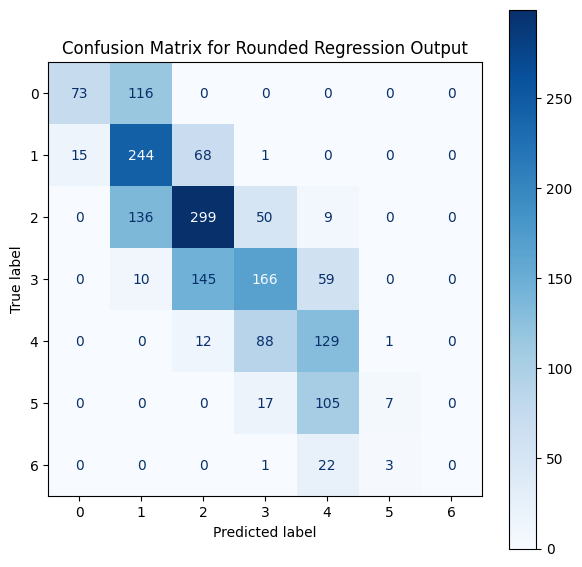


Training model for embedding type: glove
Epoch 1/10, Training Loss: 1.2904
Epoch 2/10, Training Loss: 0.9483
Epoch 3/10, Training Loss: 0.9428
Epoch 4/10, Training Loss: 0.8847
Epoch 5/10, Training Loss: 0.8469
Epoch 6/10, Training Loss: 0.8304
Epoch 7/10, Training Loss: 0.8185
Epoch 8/10, Training Loss: 0.7818
Epoch 9/10, Training Loss: 0.7931
Epoch 10/10, Training Loss: 0.7744

Evaluating model for embedding type: glove
Evaluation Results:
MSE: 0.54388
Accuracy: 0.52534
F1 Score: 0.50736
Quadratic Kappa: 0.83659


/tmp/slurm-salsabila.pranida-52509/ipykernel_1507208/1170317501.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # Load mo

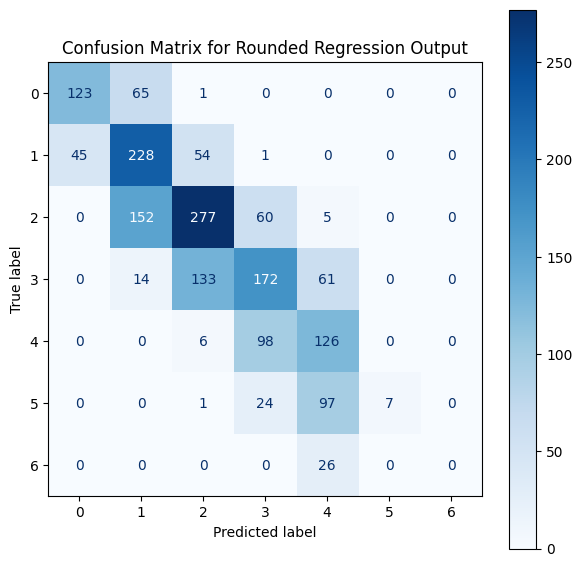


Training model for embedding type: fasttext
Epoch 1/10, Training Loss: 1.1309
Epoch 2/10, Training Loss: 0.9295
Epoch 3/10, Training Loss: 0.9011
Epoch 4/10, Training Loss: 0.8661
Epoch 5/10, Training Loss: 0.8503
Epoch 6/10, Training Loss: 0.8342
Epoch 7/10, Training Loss: 0.8238
Epoch 8/10, Training Loss: 0.7837
Epoch 9/10, Training Loss: 0.7966
Epoch 10/10, Training Loss: 0.7537

Evaluating model for embedding type: fasttext
Evaluation Results:
MSE: 0.56477
Accuracy: 0.51126
F1 Score: 0.48945
Quadratic Kappa: 0.82696


/tmp/slurm-salsabila.pranida-52509/ipykernel_1507208/1170317501.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # Load mo

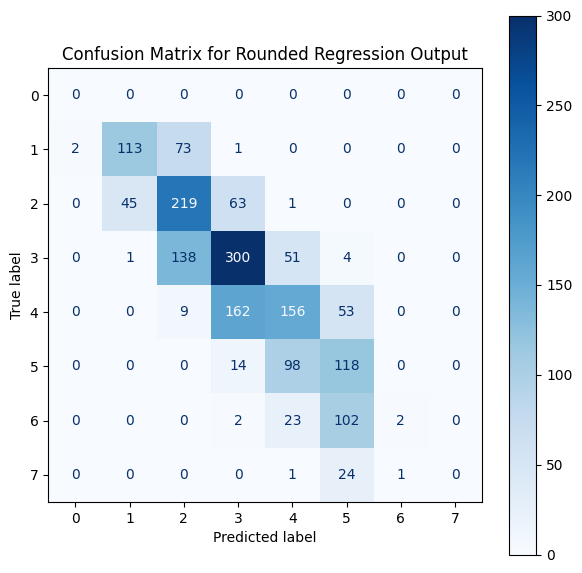

In [15]:
# Main training and evaluation loop
embedding_types = [None, "glove", "fasttext"]  # Define embedding types to experiment with
all_train_losses = []  # Initialize a list to store training losses for each embedding type
embedding_labels = [embedding_type or 'albert' for embedding_type in embedding_types]  # Readable labels for embedding types

for embedding_type in embedding_types:
    # Generate embeddings for each essay based on the current embedding type
    embeddings_and_sizes = df['essay'].apply(
        lambda x: create_combined_embedding(x, embedding_type, glove_model, fasttext_model)
    )
    df['embeddings'], embedding_sizes = zip(*embeddings_and_sizes)

    embedding_sizes = np.array(embedding_sizes)  # Convert embedding sizes to a NumPy array for further processing

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        np.stack(df['embeddings'].values),  # Feature embeddings
        df['content'].values,               # Labels (target scores for content)
        test_size=0.2,                      # 20% of data used for testing
        random_state=42                     # Set random seed for reproducibility
    )

    # Convert training and testing data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Training features
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Training labels, unsqueezed for compatibility

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Testing features
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)  # Testing labels, unsqueezed for compatibility

    # Print progress
    print(f"\nTraining model for embedding type: {embedding_type or 'albert'}")
    
    # Train the model and save its parameters
    model_path, train_losses = train_and_save_model(
        X_train_tensor,               # Training features
        y_train_tensor,               # Training labels
        X_train_tensor.shape[1],      # Input feature size
        SAVE_DIR,                     # Directory to save the model
        epochs=10,                    # Number of epochs
        batch_size=8,                 # Batch size
        learning_rate=1e-3            # Learning rate
    )

    # Append training losses to the list for plotting later
    all_train_losses.append(train_losses)

    # Evaluate the trained model
    print(f"\nEvaluating model for embedding type: {embedding_type or 'albert'}")
    evaluate_model(
        model_path,                   # Path to the trained model
        X_test_tensor,                # Testing features
        y_test_tensor.squeeze().numpy(),  # Ground truth labels (converted to NumPy format for metrics)
        SAVE_DIR                      # Directory to save evaluation artifacts
    )

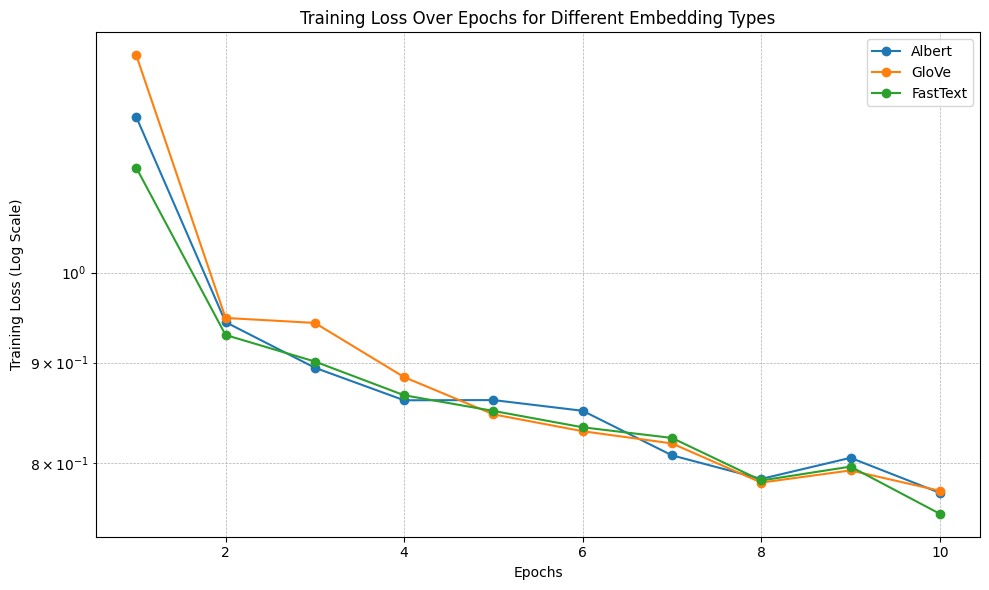

In [16]:
import matplotlib.pyplot as plt

# Define labels for the embeddings used in training
embedding_labels = ['Albert', 'GloVe', 'FastText']  # Names for the embedding types

# Initialize the plot with a specific size for better visualization
plt.figure(figsize=(10, 6))

# Define the range of epochs (assuming 10 epochs for all embeddings)
epochs = range(1, 11)

# Iterate over the training loss data and corresponding labels
for losses, label in zip(all_train_losses, embedding_labels):
    # Plot the training losses with markers for better visibility
    plt.plot(epochs, losses, label=label, marker='o')

# Use a logarithmic scale on the y-axis to highlight smaller differences in loss
plt.yscale('log')

# Add labels to the x and y axes
plt.xlabel('Epochs')  # Epochs on the x-axis
plt.ylabel('Training Loss (Log Scale)')  # Log-scaled training loss on the y-axis

# Add a title to the plot
plt.title('Training Loss Over Epochs for Different Embedding Types')

# Add a legend to distinguish the curves for each embedding type
plt.legend()

# Add a grid for better readability
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # Grid lines for both major and minor ticks

# Adjust the layout to prevent clipping of titles and labels
plt.tight_layout()

# Display the plot
plt.show()

In [17]:
content = """
    In “Let there be dark,” Paul Bogard talks about the importance of darkness.
Darkness is essential to humans. Bogard states, “Our bodies need darkness to produce the hormone melatonin, which keeps certain cancers from developing, and our bodies need darkness for sleep, sleep. Sleep disorders have been linked to diabetes, obesity, cardiovascular disease and depression and recent research suggests are main cause of “short sleep” is “long light.” Whether we work at night or simply take our tablets, notebooks and smartphones to bed, there isn’t a place for this much artificial light in our lives.” (Bogard 2). Here, Bogard talks about the importance of darkness to humans. Humans need darkness to sleep in order to be healthy.
Animals also need darkness. Bogard states, “The rest of the world depends on darkness as well, including nocturnal and crepuscular species of birds, insects, mammals, fish and reptiles. Some examples are well known—the 400 species of birds that migrate at night in North America, the sea turtles that come ashore to lay their eggs—and some are not, such as the bats that save American farmers billions in pest control and the moths that pollinate 80% of the world’s flora. Ecological light pollution is like the bulldozer of the night, wrecking habitat and disrupting ecosystems several billion years in the making. Simply put, without darkness, Earth’s ecology would collapse...” (Bogard 2). Here Bogard explains that animals, too, need darkness to survive.
""" 

In [18]:
def testContent(content, embedding_type=None, SAVE_DIR=None, glove_model=None, fasttext_model=None, min_score=0, max_score=100):
    """
    Generate a predicted content score for a given piece of content using a pre-trained model.

    Returns:
        float: Normalized score rounded to two decimal places.
    """
    # Generate the combined embedding for the input content
    embedding, actual_embedding_size = create_combined_embedding(
        content,
        embedding_type=embedding_type,
        _glove_model=glove_model if embedding_type == "glove" else None,
        _fasttext_model=fasttext_model if embedding_type == "fasttext" else None
    )

    # Convert the embedding to a PyTorch tensor and add a batch dimension
    embedding_tensor = torch.tensor(embedding, dtype=torch.float32).to(device).unsqueeze(0)

    # Define filenames for the saved embedding size and model
    embedding_size_filename = f"albert_content_embedding_size_{embedding_type or 'albert'}.npy"
    model_filename = f"albert_content_model_{embedding_type or 'albert'}.pth"
    
    # Load the expected embedding size
    embedding_size_path = os.path.join(SAVE_DIR, embedding_size_filename)
    expected_embedding_size = int(np.load(embedding_size_path))  # Ensure embedding size matches the model's input size

    # Initialize the model and load its weights
    model = MultiTaskModel(expected_embedding_size).to(device)  # Create model with the expected input shape
    model_path = os.path.join(SAVE_DIR, model_filename)
    state_dict = torch.load(model_path, map_location=device)  # Load model checkpoint
    filtered_state_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}  # Match state dict keys
    model.load_state_dict(filtered_state_dict, strict=False)  # Load weights into the model
    model.eval()  # Set the model to evaluation mode

    # Adjust embedding size if necessary
    embedding_resized = embedding_tensor[:, :expected_embedding_size]  # Ensure the embedding matches the expected size

    # Generate predictions for the content score
    with torch.no_grad():
        pred_score = model(embedding_resized)  # Predict the score using the model

    # Extract the raw score and normalize it to the desired range (0-100)
    raw_score = pred_score[0].cpu().item()  # Extract score as a scalar
    normalized_score = max(0, min(100, (raw_score - min_score) / (max_score - min_score) * 100))  # Normalize the score

    # Return the normalized score rounded to two decimal places
    return round(normalized_score, 2)

In [19]:
# Define the embedding types to evaluate
embedding_types = [None, "glove", "fasttext"]

# Dictionary to store the results for each embedding type
results = {}

# Loop through each embedding type
for embedding_type in embedding_types:
    # Assign a readable name for each embedding type
    embedding_type_name = {
        None: "ALBERT",              # Default embedding type (ALBERT)
        "glove": "ALBERT + GloVe",   # ALBERT combined with GloVe embeddings
        "fasttext": "ALBERT + FastText"  # ALBERT combined with FastText embeddings
    }[embedding_type]

    # Get the normalized score for the current embedding type
    score = testContent(
        content=content,              # Content to evaluate
        embedding_type=embedding_type,  # Embedding type (ALBERT, GloVe, or FastText)
        SAVE_DIR=SAVE_DIR,            # Directory containing saved model files
        glove_model=glove_model,      # Pre-loaded GloVe embeddings
        fasttext_model=fasttext_model # Pre-loaded FastText embeddings
    )

    # Store the score in the results dictionary
    results[embedding_type_name] = score

# Display the results for each embedding type
for embedding_name, score in results.items():
    print(f"{embedding_name}: {score:.2f}")  # Print embedding name and score rounded to two decimal places

ALBERT: 3.79
ALBERT + GloVe: 3.58
ALBERT + FastText: 3.91


/tmp/slurm-salsabila.pranida-52509/ipykernel_1507208/1948540768.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)